# Creating the DataFrame and Importing dependencies

In [151]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score


In [153]:
df_purch = pd.read_csv("purchase+data.csv")

In [155]:
df_purch.rename(columns={"Sex": "Gender"}, inplace=True)

In [157]:
df_purch.head()

,ID,Day,Incidence,Product,Quantity,Last_Inc_Product,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


# Deploying Scaler , PCA and Clustring model 

In [161]:
with open('scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
   
with open('pca.pickle', 'rb') as f:
    pca = pickle.load(f)


with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

In [163]:
features = df_purch[['Gender', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
scaled_df_purch = scaler.transform(features)

In [165]:
df_purch_pca = pca.transform(scaled_df_purch)

C:\Users\sandy\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [167]:
clustered_pca_df_purch = model.predict(df_purch_pca)

In [169]:
df_purchase_pred = df_purch.copy()

In [171]:
df_purchase_pred['Segment'] = clustered_pca_df_purch

In [173]:
df_purchase_pred.head()

,ID,Day,Incidence,Product,Quantity,Last_Inc_Product,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_4,Promotion_5,Gender,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,47,1,110866,1,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,47,1,110866,1,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0


In [176]:
segment_dummies = pd.get_dummies(clustered_pca_df_purch, prefix = 'Segment', prefix_sep = '_')
df_purchase_pred = pd.concat([df_purchase_pred, segment_dummies], axis = 1)

df_pa = df_purchase_pred

# Analysing the data

In [179]:
temp1 = df_purchase_pred[['ID', 'Incidence']].groupby(['ID'], as_index = False).count()

In [180]:
temp1 = temp1.set_index('ID')

In [182]:
temp1 = temp1.rename(columns= {'Incidence': 'N_visits'})

In [184]:
temp2 = df_purchase_pred[['ID', 'Incidence']].groupby(['ID'], as_index = False).sum()

In [185]:
temp2 = temp2.set_index('ID')

In [186]:
temp2 = temp2.rename(columns= {'Incidence': 'N_purchase'})

In [187]:
temp3 = temp1.join(temp2)

In [188]:
temp3['Average_N_Purchase'] = temp3['N_purchase'] / temp3['N_visits'] 

In [189]:
temp4 = df_purchase_pred[['ID', 'Segment']].groupby(['ID'],as_index = False).mean()

In [190]:
temp4 = temp4.set_index(['ID'])

In [191]:
df_purchase_descr = temp3.join(temp4)

In [192]:
df_purchase_descr.Segment = df_purchase_descr.Segment.astype(int)

In [193]:
segm_prop = df_purchase_descr[['N_purchase', 'Segment']].groupby(['Segment']).count() / df_purchase_descr.shape[0]
segm_prop = segm_prop.rename(columns = {'N_purchase': 'Segment Sale Proportions'})
segm_prop.head()

,Segment Sale Proportions
Segment,
0,0.478
1,0.258
2,0.134
3,0.130


([], [])

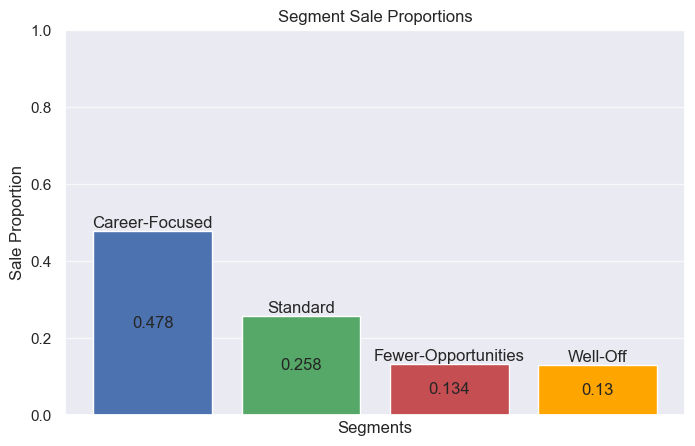

In [194]:
segments = ['Career-Focused', 'Standard', 'Fewer-Opportunities',  'Well-Off' ]
plt.figure(figsize=(8, 5))
barplot = plt.bar(segm_prop.index,segm_prop['Segment Sale Proportions'], color = ('b', 'g', 'r', 'orange'))
plt.bar_label(barplot, labels = segments, label_type ='edge')
plt.bar_label(barplot, labels =  segm_prop['Segment Sale Proportions'], label_type ='center')
plt.xlabel('Segments')
plt.ylabel('Sale Proportion')
plt.title('Segment Sale Proportions')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.7)
plt.xticks([])


In [195]:
segments_mean = df_purchase_descr.groupby(['Segment']).mean()
segments_mean

,N_visits,N_purchase,Average_N_Purchase
Segment,,,
0,118.280335,31.861925,0.248308
1,118.589147,29.806202,0.246732
2,116.044776,26.761194,0.231952
3,113.092308,21.307692,0.189554


In [196]:
segments_std = df_purchase_descr.groupby(['Segment']).std()
segments_std

,N_visits,N_purchase,Average_N_Purchase
Segment,,,
0,32.783746,39.386175,0.172803
1,20.147740,21.874671,0.154135
2,21.404781,19.575874,0.147885
3,15.577150,10.895703,0.092894


Text(0.5, 1.0, 'Average Number of Store Visits by Segment')

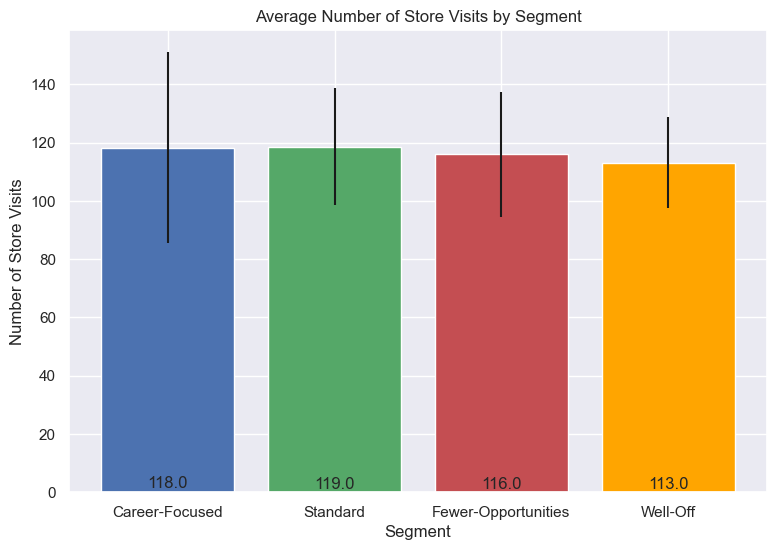

In [197]:
plt.figure(figsize = (9, 6))
plt.bar(x = (0, 1, 2, 3),
        tick_label = ('Career-Focused', 'Standard', 'Fewer-Opportunities', 'Well-Off'), 
        height = segments_mean['N_visits'],
        yerr = segments_std['N_visits'],
        color = ('b', 'g', 'r', 'orange'))
plt.bar_label(barplot, labels =  segments_mean['N_visits'].round(0), label_type ='edge')

plt.xlabel('Segment')
plt.ylabel('Number of Store Visits')
plt.title('Average Number of Store Visits by Segment')


Text(0.5, 1.0, 'Average Number of Sales by Segment')

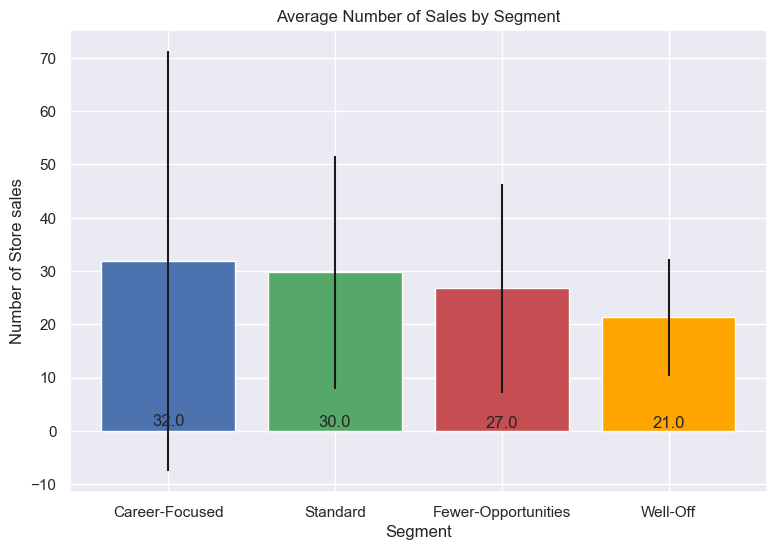

In [198]:

plt.figure(figsize = (9, 6))
plt.bar(x = (0, 1, 2, 3),
        tick_label = ('Career-Focused', 'Standard', 'Fewer-Opportunities', 'Well-Off'), 
        height = segments_mean['N_purchase'],
        yerr = segments_std['N_purchase'],
        color = ('b', 'g', 'r', 'orange'))
plt.bar_label(barplot, labels =  segments_mean['N_purchase'].round(0), label_type ='edge')

plt.xlabel('Segment')
plt.ylabel('Number of Store sales')
plt.title('Average Number of Sales by Segment')

# Product Choice

In [216]:
# filtering only for first product
df_purchase_incidence = df_purchase_pred[df_purchase_pred['Incidence'] == 1]

In [218]:
product_dummies = pd.get_dummies(df_purchase_incidence['Product'], prefix = 'Product', prefix_sep = '_')
product_dummies['Segment'], product_dummies['ID'] = df_purchase_incidence['Segment'], df_purchase_incidence['ID']
product_dummies

,Product_1,Product_2,Product_3,Product_4,Product_5,Segment,ID
6,False,True,False,False,False,0,200000001
11,False,False,False,False,True,0,200000001
19,True,False,False,False,False,0,200000001
24,False,False,False,True,False,0,200000001
29,False,True,False,False,False,0,200000001
...,...,...,...,...,...,...,...
58621,False,True,False,False,False,0,200000500
58648,True,False,False,False,False,0,200000500
58674,False,True,False,False,False,0,200000500
58687,False,True,False,False,False,0,200000500


In [220]:
temp = product_dummies.groupby(['ID'], as_index = True).mean()

In [222]:
mean_product_choice = temp.groupby(['Segment'], as_index = True).mean()

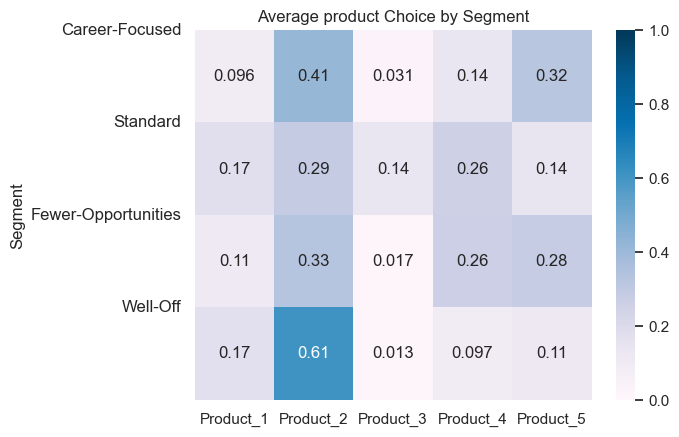

In [224]:
sns.heatmap(mean_product_choice,
            vmin = 0, 
            vmax = 1,
            cmap = 'PuBu',
            annot = True)
plt.yticks([0, 1, 2, 3], ['Career-Focused', 'Standard', 'Fewer-Opportunities', 'Well-Off'], rotation = 0 , fontsize = 12)
plt.title('Average product Choice by Segment')
plt.show()

#  Revenue

In [227]:
temp = df_purchase_pred[df_purchase_pred['Product'] == 1].copy()  # Copy to avoid SettingWithCopyWarning
temp['Revenue Product 1'] = temp['Price_1'] * temp['Quantity']

segments_product_revenue = pd.DataFrame()
segments_product_revenue[['Segment', 'Revenue Product 1']] = (
    temp[['Segment', 'Revenue Product 1']]
    .groupby(['Segment'], as_index=False)
    .sum()
)

segments_product_revenue


,Segment,Revenue Product 1
0,0,2219.98
1,1,2538.54
2,2,687.07
3,3,860.06


In [229]:
temp = df_purchase_pred[df_purchase_pred['Product'] == 2].copy()
temp.loc[:, 'Revenue Product 2'] = temp['Price_2'] * temp['Quantity']
segments_product_revenue[['Segment', 'Revenue Product 2']] = temp[['Segment', 'Revenue Product 2']].groupby(['Segment'], as_index = False).sum()

In [231]:
temp = df_purchase_pred[df_purchase_pred['Product'] == 3].copy()
temp.loc[:,'Revenue Product 3'] = temp['Price_3']*temp['Quantity']
segments_product_revenue[['Segment','Revenue Product 3']] = temp[['Revenue Product 3','Segment']].groupby(['Segment'], as_index = False).sum()

In [233]:
temp = df_purchase_pred[df_purchase_pred['Product'] == 4].copy()
temp.loc[:,'Revenue Product 4'] = temp['Price_4']*temp['Quantity']
segments_product_revenue[['Segment','Revenue Product 4']] = temp[['Revenue Product 4','Segment']].groupby(['Segment'], as_index = False).sum()

In [235]:
temp = df_purchase_pred[df_purchase_pred['Product'] == 5].copy()
temp.loc[:,'Revenue Product 5'] = temp['Price_5']*temp['Quantity']
segments_product_revenue[['Segment','Revenue Product 5']] = temp[['Revenue Product 5','Segment']].groupby(['Segment'], as_index = False).sum()

In [237]:
segments_product_revenue['Total Revenue'] = (segments_product_revenue['Revenue Product 1'] +
                                           segments_product_revenue['Revenue Product 2'] +
                                           segments_product_revenue['Revenue Product 3'] +
                                           segments_product_revenue['Revenue Product 4'] +
                                           segments_product_revenue['Revenue Product 5'] )
segments_product_revenue

,Segment,Revenue Product 1,Revenue Product 2,Revenue Product 3,Revenue Product 4,Revenue Product 5,Total Revenue
0,0,2219.98,11145.04,1490.07,7042.99,20877.38,42775.46
1,1,2538.54,4264.71,4232.67,7944.90,3668.17,22648.99
2,2,687.07,2328.69,170.60,2986.62,3928.10,10101.08
3,3,860.06,4029.87,128.18,1065.59,1147.35,7231.05


In [239]:
segments_product_revenue['Segment Sale Proportions'] = segm_prop['Segment Sale Proportions']
segments_product_revenue['Segment'] = segments_product_revenue['Segment'].map({0:'Career-Focused',
                                                                           1:'Standard',
                                                                           2:'Fewer-Opportunities',
                                                                           3:'Well-Off'})
segments_product_revenue = segments_product_revenue.set_index(['Segment'])
segments_product_revenue

,Revenue Product 1,Revenue Product 2,Revenue Product 3,Revenue Product 4,Revenue Product 5,Total Revenue,Segment Sale Proportions
Segment,,,,,,,
Career-Focused,2219.98,11145.04,1490.07,7042.99,20877.38,42775.46,0.478
Standard,2538.54,4264.71,4232.67,7944.90,3668.17,22648.99,0.258
Fewer-Opportunities,687.07,2328.69,170.60,2986.62,3928.10,10101.08,0.134
Well-Off,860.06,4029.87,128.18,1065.59,1147.35,7231.05,0.130


In [241]:
df = segments_product_revenue.iloc[:,:6]

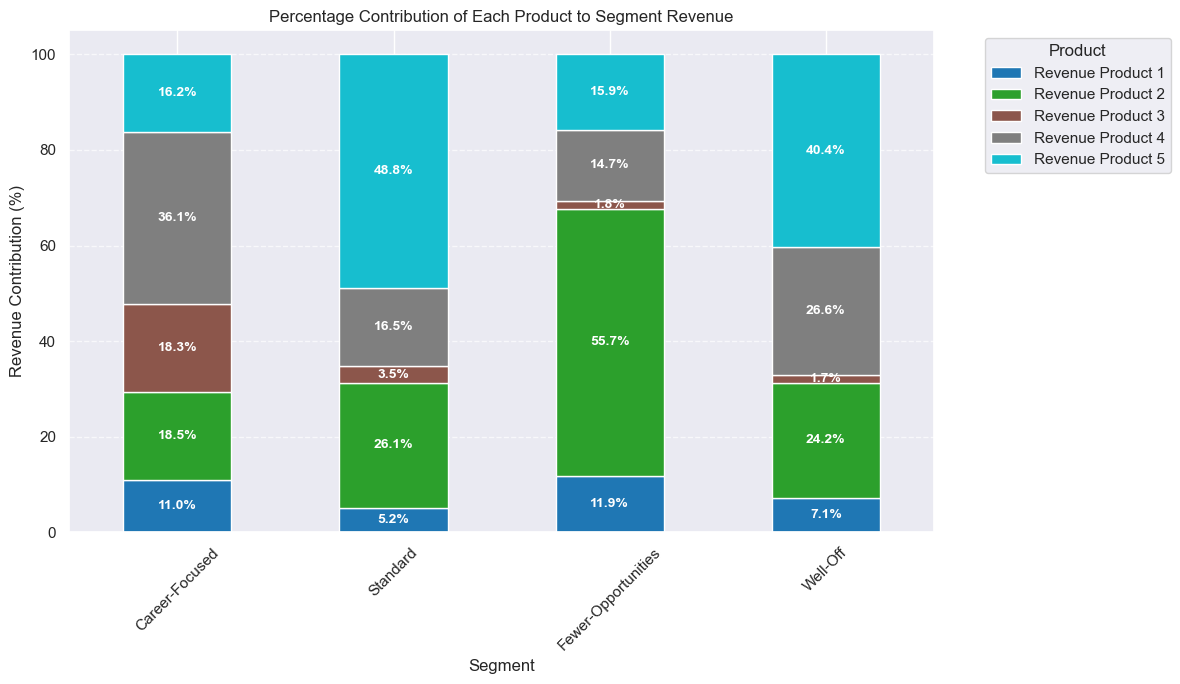

In [243]:
data = {
    'Segment': ['Career-Focused', 'Standard', 'Fewer-Opportunities', 'Well-Off'],
    'Revenue Product 1': [2548.87, 2219.98, 860.06, 676.74],
    'Revenue Product 2': [4293.85, 11145.04, 4029.87, 2299.55],
    'Revenue Product 3': [4246.46, 1490.07, 128.18, 156.81],
    'Revenue Product 4': [8406.18, 7042.99, 1065.59, 2525.34],
    'Revenue Product 5': [3763.03, 20877.38, 1147.35, 3833.24],
    'Total Revenue': [23258.39, 42775.46, 7231.05, 9491.68]
}

df = pd.DataFrame(data)

# Convert revenue values into percentages per segment
product_columns = ['Revenue Product 1', 'Revenue Product 2', 'Revenue Product 3', 'Revenue Product 4', 'Revenue Product 5']
df_percentage = df.copy()
df_percentage[product_columns] = df_percentage[product_columns].div(df_percentage['Total Revenue'], axis=0) * 100  # Convert to %

# Plotting a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))
bars = df_percentage.set_index('Segment')[product_columns].plot(kind='bar', stacked=True, colormap='tab10', ax=ax)

# Adding percentage labels inside the bars
for i, segment in enumerate(df_percentage['Segment']):
    bottom = 0  # Initial bottom value for stacking
    for Product in product_columns:
        value = df_percentage.loc[i, Product]
        if value > 0:  # Avoid placing labels for zero values
            ax.text(i, bottom + value / 2, f"{value:.1f}%", ha='center', va='center', fontsize=10, color='white', fontweight='bold')
        bottom += value  # Update bottom position for stacking

# Labels and formatting
plt.title("Percentage Contribution of Each Product to Segment Revenue")
plt.xlabel("Segment")
plt.ylabel("Revenue Contribution (%)")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# Creating model 

In [246]:
Y = df_pa['Incidence'] 

In [248]:
X = df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']]

In [250]:
model_product_choice = LogisticRegression(solver = 'sag', multi_class='multinomial' ) 

In [252]:
model_product_choice.fit(X,Y)

C:\Users\sandy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='sag')

In [254]:
product_choice = df_pa[df_pa['Incidence']==1]

In [256]:
product_choice

,ID,Day,Incidence,Product,Quantity,Last_Inc_Product,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,0,True,False,False,False
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,0,True,False,False,False
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,0,True,False,False,False
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,0,True,False,False,False
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,0,True,False,False,False
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,0,True,False,False,False
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,0,True,False,False,False
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,0,True,False,False,False


In [258]:
Y = product_choice['Product']

In [260]:
X = product_choice[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']]

In [262]:
model_product_choice = LogisticRegression(solver = 'sag', multi_class='multinomial' ) 

In [264]:
model_product_choice.fit(X,Y)

C:\Users\sandy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='sag')

In [266]:
model_product_choice.coef_

array([[-3.91594058,  0.65846741,  2.41777865,  0.70409713, -0.20209262],
       [ 1.2746205 , -1.87985215, -0.21261492, -0.20633468,  0.58787898],
       [ 1.62414507,  0.56209041,  0.50072951,  1.03947621,  0.45274348],
       [ 0.57454697,  0.39559237, -1.40057124, -1.24623701,  0.24936128],
       [ 0.44262804,  0.26370195, -1.30532201, -0.29100165, -1.08789112]])

# Demand Elasticity 

In [269]:


pc_coef = pd.DataFrame(model_product_choice.coef_) 

coefs = ['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']
pc_coef.columns = coefs 

prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
pc_coef.index = prices  

pc_coef = pc_coef.round(2)  

pc_coef


,Product_1,Product_2,Product_3,Product_4,Product_5
Price_1,-3.92,0.66,2.42,0.70,-0.20
Price_2,1.27,-1.88,-0.21,-0.21,0.59
Price_3,1.62,0.56,0.50,1.04,0.45
Price_4,0.57,0.40,-1.40,-1.25,0.25
Price_5,0.44,0.26,-1.31,-0.29,-1.09


In [271]:
temp = pc_coef.iloc[:,: 5]

In [273]:
meanprice= [df_pa['Price_1'].mean(),
df_pa['Price_2'].mean(),
df_pa['Price_3'].mean(),
df_pa['Price_4'].mean(),
df_pa['Price_5'].mean()]

In [275]:
meanprice

[1.392074352989283,
 1.7809989266181656,
 2.0067887141567136,
 2.1599453086398714,
 2.65479767604314]

In [277]:
meanquant= {df_pa.loc[df_pa['Product'] == 1, 'Quantity'].mean(),
df_pa.loc[df_pa['Product'] == 2, 'Quantity'].mean(),
df_pa.loc[df_pa['Product'] == 3, 'Quantity'].mean(),
df_pa.loc[df_pa['Product'] == 4, 'Quantity'].mean(),
df_pa.loc[df_pa['Product'] == 5, 'Quantity'].mean()}

In [279]:
meanquant

{2.24949779027722,
 2.8243064729194187,
 3.0327980867782713,
 3.494074074074074,
 3.5600475624256838}

In [281]:
products = ['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']
meanprice = dict(zip(products, meanprice))  # Convert list to dictionary
meanquant = dict(zip(products, meanquant))  # Convert list to dictionary


In [287]:
# Calculating the Demand Elasticity
def calculate_elasticity(temp, meanprice, meanquant):
    elasticity = {}

    # Map each product to its corresponding price row
    price_map = {f'Product_{i}': f'Price_{i}' for i in range(1, 6)}

    for product in temp.columns:
        if product in price_map:  # Ensure product is mapped to a price row
            price_row = price_map[product]  
            
            price_coef = temp.loc[price_row, product]  
            mean_price = meanprice[product]  
            mean_quantity = meanquant[product]

            elasticity[product] = price_coef * (mean_price / mean_quantity)

    return pd.DataFrame.from_dict(elasticity, orient='index', columns=['Elasticity'])

# Call the function
elasticity_df = calculate_elasticity(temp, meanprice, meanquant)

# Print result
print(elasticity_df)

           Elasticity
Product_1   -1.932131
Product_2   -0.940515
Product_3    0.330848
Product_4   -0.772717
Product_5   -1.286389


In [289]:
elasticity_df

,Elasticity
Product_1,-1.932131
Product_2,-0.940515
Product_3,0.330848
Product_4,-0.772717
Product_5,-1.286389


In [291]:
elasticity_df_sorted = elasticity_df.sort_values(by='Elasticity')

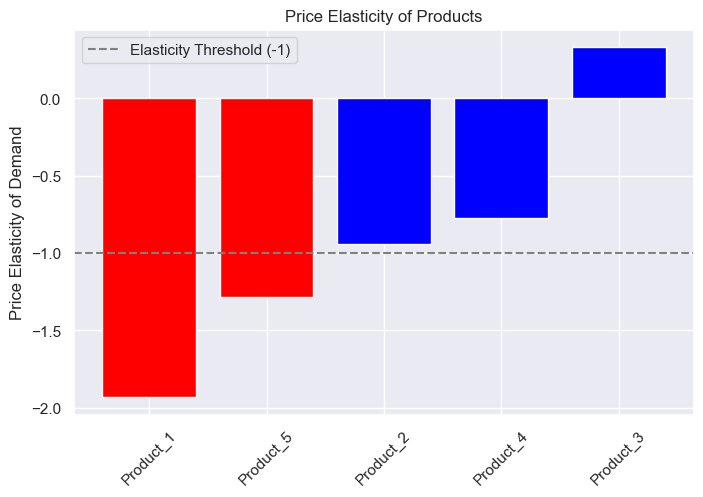

In [293]:
plt.figure(figsize=(8, 5))
plt.bar(elasticity_df_sorted.index, elasticity_df_sorted['Elasticity'], color=['red' if x < -1 else 'blue' for x in elasticity_df_sorted['Elasticity']])
plt.axhline(y=-1, color='gray', linestyle='--', label='Elasticity Threshold (-1)')
plt.ylabel("Price Elasticity of Demand")
plt.title("Price Elasticity of Products")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [295]:
# Elasticity to Optimize Pricing Strategy

# If demand is elastic (<-1) → Lower prices to increase revenue.
# If demand is inelastic (>-1) → Increase prices to maximize profit.
# Test price simulations by slightly adjusting prices and predicting new demand.

In [298]:
import numpy as np
import pandas as pd

def optimize_prices(elasticity_df, current_prices, meanquant, price_changes=[-20, -10, -5, 0, 5, 10, 20]):
    best_revenue = -np.inf
    best_prices = None
    best_change = 0
    
    results = []

    for change in price_changes:
        # Convert lists to NumPy arrays to avoid type errors
        new_prices = {k: v * (1 + change / 100) for k, v in current_prices.items()}
        
        # Convert meanquant to array to support multiplication
        new_quantities = {k: meanquant[k] * (1 + elasticity_df.loc[k, 'Elasticity'] * (change / 100)) for k in new_prices.keys()}

        # Calculate revenue
        revenue = sum(new_prices[k] * new_quantities[k] for k in new_prices.keys())
        results.append((change, revenue))

        # Track best revenue
        if revenue > best_revenue:
            best_revenue = revenue
            best_prices = new_prices
            best_change = change

    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=["Price Change (%)", "Revenue"])
    
    return best_change, best_prices, best_revenue, results_df

# ✅ Ensure meanprice and meanquant are converted to NumPy arrays
meanprice = np.array([1.392074352989283, 1.7809989266181656, 2.0067887141567136, 2.1599453086398714, 2.65479767604314])
meanquant = np.array([2.24949779027722, 2.8243064729194187, 3.0327980867782713, 3.494074074074074, 3.5600475624256838])

# Convert prices to a dictionary for easy access
current_prices = dict(zip(['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5'], meanprice))
meanquant_dict = dict(zip(['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5'], meanquant))

# Run Optimization
best_change, best_prices, best_revenue, results_df = optimize_prices(elasticity_df, current_prices, meanquant_dict)

print(f"Best Price Change: {best_change}%")
print(f"Optimal Revenue: ${best_revenue:.2f}")
print("Optimal Prices:", best_prices)

# Display all results
print(results_df)


Best Price Change: 10%
Optimal Revenue: $31.43
Optimal Prices: {'Product_1': 1.5312817882882113, 'Product_2': 1.9590988192799823, 'Product_3': 2.207467585572385, 'Product_4': 2.3759398395038587, 'Product_5': 2.9202774436474543}
   Price Change (%)    Revenue
0               -20  29.277934
1               -10  30.529518
2                -5  30.954629
3                 0  31.245955
4                 5  31.403494
5                10  31.427246
6                20  31.073391


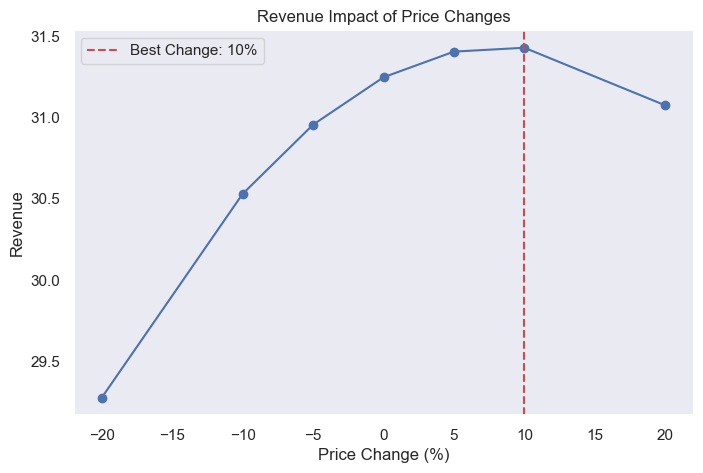

In [300]:

plt.figure(figsize=(8, 5))
plt.plot(results_df["Price Change (%)"], results_df["Revenue"], marker='o', linestyle='-')
plt.xlabel("Price Change (%)")
plt.ylabel("Revenue")
plt.title("Revenue Impact of Price Changes")
plt.axvline(best_change, color='r', linestyle='--', label=f"Best Change: {best_change}%")
plt.legend()
plt.grid()
plt.show()


Optimal Price Changes per Product:
Product_1: -20%
Product_2: 5%
Product_3: 20%
Product_4: 10%
Product_5: -10%


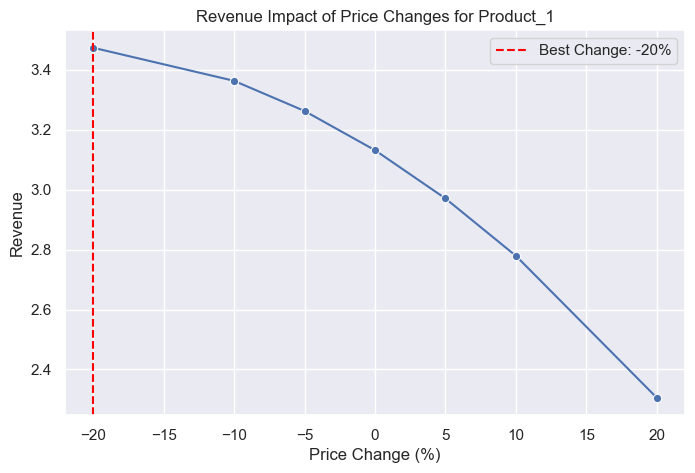

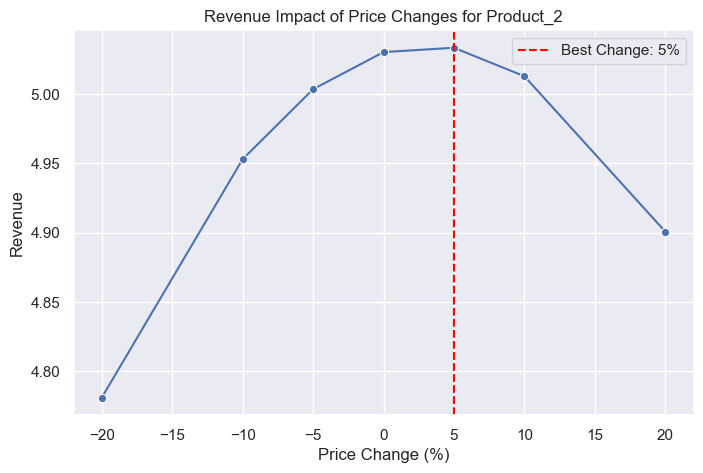

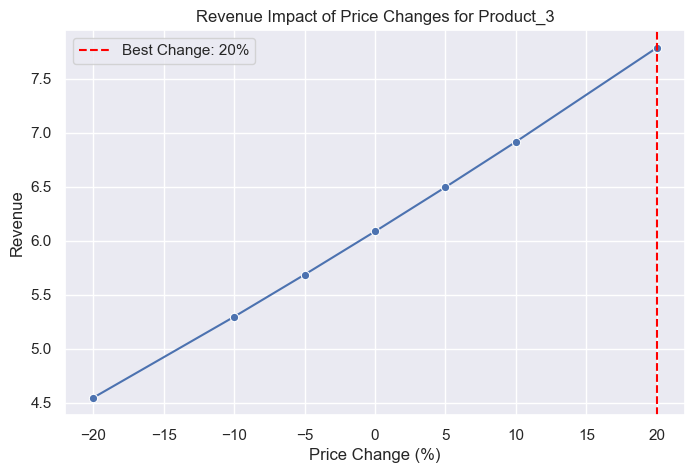

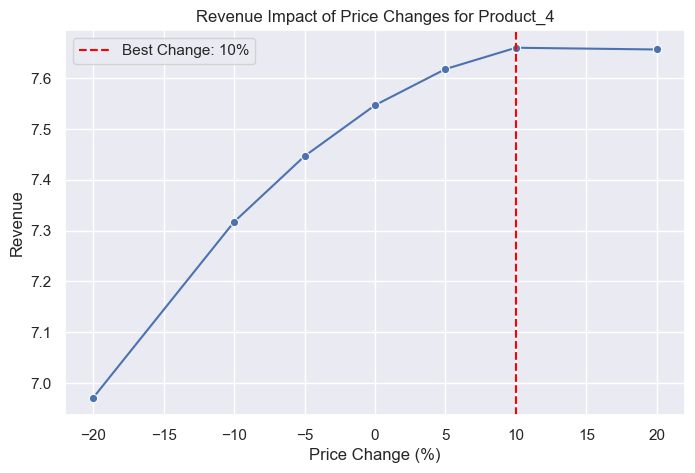

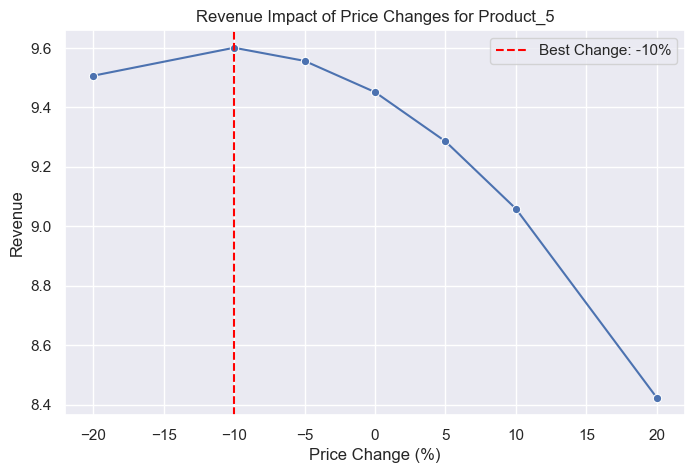

In [308]:
def optimize_product_prices(elasticity_df, current_prices, meanquant, price_changes=[-20, -10, -5, 0, 5, 10, 20]):
    best_changes = {}
    revenue_impacts = {}

    for product in current_prices.keys():
        best_revenue = -np.inf
        best_change = 0
        results = []

        for change in price_changes:
            # Adjust price
            new_price = current_prices[product] * (1 + change / 100)
            # Adjust quantity using elasticity
            new_quantity = meanquant[product] * (1 + elasticity_df.loc[product, 'Elasticity'] * (change / 100))
            # Calculate revenue
            revenue = new_price * new_quantity
            results.append((change, revenue))

            # Track best revenue
            if revenue > best_revenue:
                best_revenue = revenue
                best_change = change

        # Save best change
        best_changes[product] = best_change
        revenue_impacts[product] = pd.DataFrame(results, columns=["Price Change (%)", "Revenue"])

    return best_changes, revenue_impacts

# Run per-product analysis
best_product_changes, product_revenue_dfs = optimize_product_prices(elasticity_df, current_prices, meanquant_dict)

# Print recommendations
print("Optimal Price Changes per Product:")
for product, change in best_product_changes.items():
    print(f"{product}: {change}%")

# Plot each product's revenue impact
for product, df in product_revenue_dfs.items():
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df, x="Price Change (%)", y="Revenue", marker="o")
    plt.axvline(x=best_product_changes[product], color='red', linestyle='dashed', label=f"Best Change: {best_product_changes[product]}%")
    plt.title(f"Revenue Impact of Price Changes for {product}")
    plt.legend()
    plt.show()
